# Data-Driven Strategy for Microsoft Film Studio's Debut Release
***
<b>Authors:</b> Wes Newcomb, Jared Mitchell, Seraj Khazei

## Overview
***
Microsoft has recently decided to join Apple and Amazon as big tech firms rush to the film industry. However, the film industry is notoriously difficult to navigate, with only roughly 30% of films breaking a profit on average. While there are some more archaic methods that studios have utilized for years to boost the chances of film profitability, there is no legacy approach that guarantees the profitability of a film. But this is no longer the case. The data revolution has brought about new opportunities for industry insight. As this team of analysts will demonstrate, analyzing large datasets using machine methods enables humans to reap crisp insights into the nature of the film industry; as a result, Microsoft hired us to create a formula for maximizing profits and minimizing risks in order to secure a victory in its foray into the world of cinema.

## Data
***
In order to answer the questions ahead of us, we have implemented datasets from <a href="https://www.imdb.com/">imdb.com</a>, <a href="https://www.the-numbers.com/">thenumbers.com</a>, and <a href="https://www.themoviedb.org/">themoviedb.com</a>. We chose each for their sizes (all are sufficiently large as to provide an accurate sample of the total movies population), and because they are all independently maintained (thus ensuring the quality of the data). 

To further optimize our recommendations to Microsoft Studios, we decided to focus only on films made during during or after the year 2000 as this technique filters in favor of modern trends. 

Finally, it is important to know that when we refer to the profitability of a film, we are talking about whether that film made more that twice its budget in gross revenue. Movie profits are obscured for many reasons, but a solid the aforementioned formula serves as a decent measure of the state of profitability of a movie.

## Analysis
***

In [1]:
# import all necessary modules for analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image

In [2]:
# read in all necessary data files

imdb_name = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
imdb_crew = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
imdb_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')

tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col='Unnamed: 0')

tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

In [3]:
# useful functions and conversion keys

def launder(money):
    money = money.replace('$', '')
    
    for i in range(len(money)//4):
        money = money.replace(',', '')
    return int(money)


def str_to_list(x):
    x = x.replace('[', '')
    x = x.replace(']', '')
    r_list = x.split(',')
    r_list = [x.strip() for x in r_list]
    
    return r_list


def imdb_format(person):
    
    if ',' in person:
        r_person = person.split(',')
    else:
        r_person = [person]
    return r_person


# a key to convert genre ids to genre names for the tmdb dataset
    
num_to_genre =    {'28':'Action',
                    '12':'Adventure',
                    '16':'Animation',
                    '35':'Comedy',
                    '80':'Crime',
                    '99':'Documentary',
                    '18':'Drama',
                    '10751':'Family',
                    '14':'Fantasy',
                    '36':'History',
                    '27':'Horror',
                    '10402':'Music',
                    '9648':'Mystery',
                    '10749':'Romance',
                    '878':'Science Fiction',
                    '10770':'TV Movie',
                    '53':'Thriller',
                    '10752':'War',
                    '37':'Western'}

### Clean And Join Datasets

In [4]:
# clean tn dataset
tn_df = tn_movie_budgets.drop(['id','domestic_gross'], axis=1)
tn_df['production_budget'] = tn_df['production_budget'].apply(launder)
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].apply(launder)
tn_df['release_date'] = tn_df['release_date'].map(lambda date: date[-4:])
tn_df.dropna(inplace=True)
tn_df['profits'] = tn_df['worldwide_gross'] - 2*tn_df['production_budget']
tn_df['profitable'] = tn_df['profits'] > 0

In [5]:
# clean tmdb dataset
tmdb_df = tmdb_movies.drop(['id','original_language','original_title','popularity',
                            'release_date','vote_average','vote_count'], axis=1)
tmdb_df['genre_ids'] = tmdb_df['genre_ids'].apply(str_to_list)
tmdb_df.dropna(inplace=True)
tmdb_df = tmdb_df.explode('genre_ids', ignore_index=True)
tmdb_df = tmdb_df.replace('', np.nan)
tmdb_df.dropna(inplace=True)
tmdb_df['genre_ids'] = tmdb_df['genre_ids'].map(lambda x: num_to_genre[x])

In [6]:
# clean imdb datasets
imdb_people = imdb_name[imdb_name['death_year'].isna()]
imdb_people = imdb_people.drop(['birth_year','death_year','primary_profession','known_for_titles'], axis=1)

imdb_casts = imdb_principals.drop(['ordering','category','job','characters'], axis=1)
imdb_movies = imdb_basics.drop(['original_title', 'runtime_minutes'], axis=1)

In [7]:
# join imdb datasets for one large imdb dataframe
imdb_people.set_index('nconst', inplace=True)
imdb_casts.set_index('nconst', inplace=True)
imdb_cast_per_film = imdb_casts.join(imdb_people)

imdb_cast_per_film.set_index('tconst', inplace=True)
imdb_movies.set_index('tconst', inplace=True)
imdb_df = imdb_cast_per_film.join(imdb_movies)

In [8]:
# clean final imdb dataset
imdb_df.dropna(inplace=True)
imdb_df.reset_index(inplace=True)
imdb_df.drop('tconst', axis=1, inplace=True)

In [9]:
# preview datasets
tn_df.head()

,release_date,movie,production_budget,worldwide_gross,profits,profitable
0,2009,Avatar,425000000,2776345279,1926345279,True
1,2011,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,224463875,True
2,2019,Dark Phoenix,350000000,149762350,-550237650,False
3,2015,Avengers: Age of Ultron,330600000,1403013963,741813963,True
4,2017,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,682721747,True


In [10]:
tmdb_df.head()

,genre_ids,title
0,Adventure,Harry Potter and the Deathly Hallows: Part 1
1,Fantasy,Harry Potter and the Deathly Hallows: Part 1
2,Family,Harry Potter and the Deathly Hallows: Part 1
3,Fantasy,How to Train Your Dragon
4,Adventure,How to Train Your Dragon


In [11]:
imdb_df.head()

,primary_name,primary_title,start_year,genres
0,Gulzar,Sunghursh,2013,"Action,Crime,Drama"
1,Dilip Kumar,Sunghursh,2013,"Action,Crime,Drama"
2,Vyjayanthimala,Sunghursh,2013,"Action,Crime,Drama"
3,Anjana Rawail,Sunghursh,2013,"Action,Crime,Drama"
4,Aruna Irani,One Day Before the Rainy Season,2019,"Biography,Drama"


### Percent Probability of Profitability By Genre

In [12]:
df_grand = tmdb_df.set_index('title').join(tn_df.set_index('movie'))

In [13]:
df_grand.dropna(inplace=True)
df_grand['release_date'] = df_grand['release_date'].apply('int64')
df_grand = df_grand[(df_grand['release_date'] > 1999) & (df_grand['release_date'] < 2019)]

In [14]:
# get profitabiltity numbers by genre
num_profitable_films = df_grand.groupby('genre_ids')['profitable'].value_counts()

In [15]:
# clean proftiabilty numbers for visual display
x = list(num_profitable_films.index)
y = list(num_profitable_films.values)

x1 = [y[i] for i in range(len(x)) if x[i][1]==True]
y1 = [y[2*i]+y[2*i+1] for i in range(len(y)//2)]

genres = [x[i*2][0] for i in range(len(x)//2)]
prof_rates = [round(x2*100/y2,1) for x2,y2 in zip(x1,y1)]

genre_prof_rate_list = [(rate,genre) for rate, genre in zip(prof_rates, genres)]
sorted_by_second = sorted(genre_prof_rate_list, key=lambda tup: tup[0], reverse=True)



x2 = [i[1] for i in sorted_by_second[:8]]
y2 = [i[0] for i in sorted_by_second[:8]]

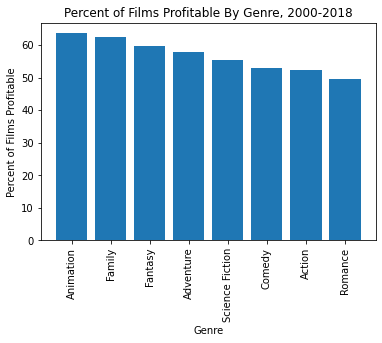

In [16]:
fig, ax = plt.subplots()

ax.bar(x2, y2);
plt.xticks(rotation=90);
plt.xlabel('Genre')
plt.ylabel('Percent of Films Profitable')
plt.title('Percent of Films Profitable By Genre, 2000-2018')
plt.show()

### Number of Films Made Each Year By Genre

In [17]:
genre_freq_by_year = df_grand.groupby(['release_date','genre_ids'])['production_budget'].count()

In [18]:
x = list(genre_freq_by_year.index)
y = list(genre_freq_by_year.values)

In [19]:
plt_dict = {k[1]:[] for k in x}

for k,v in zip(x,y):
    tup_obj = (k[0],v)
    
    plt_dict[k[1]].append(tup_obj)

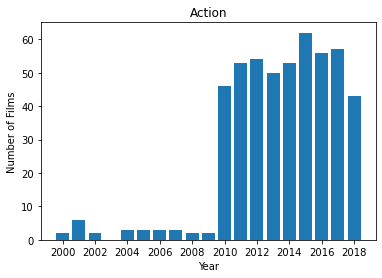

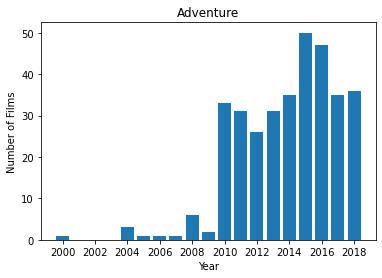

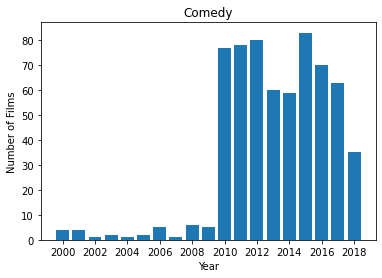

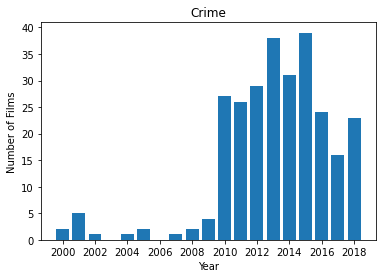

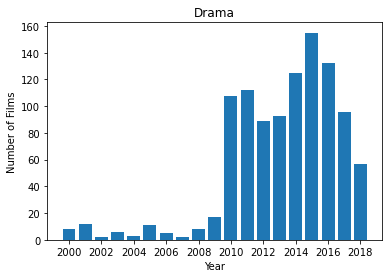

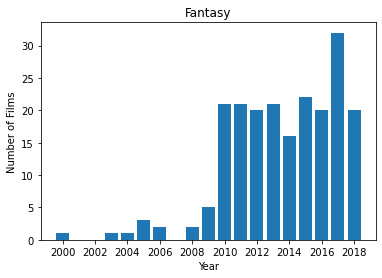

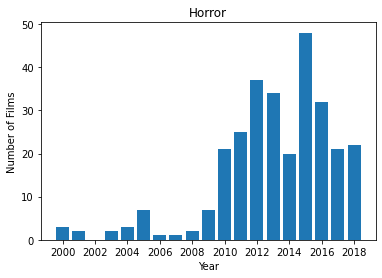

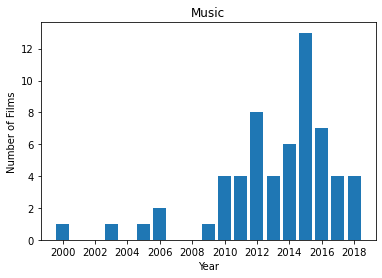

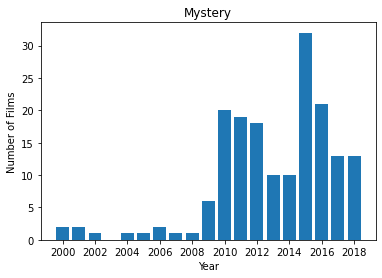

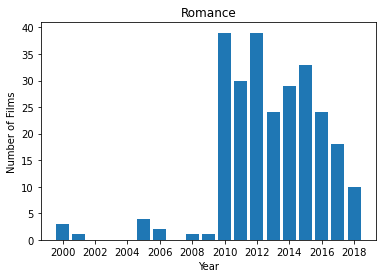

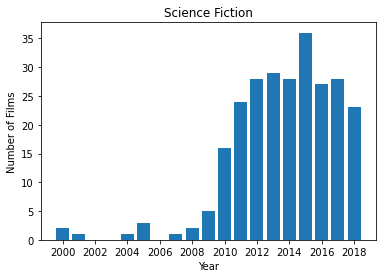

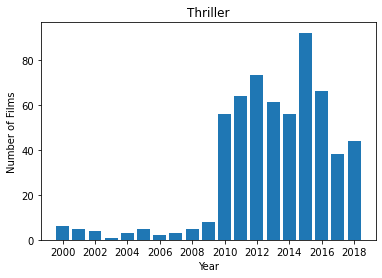

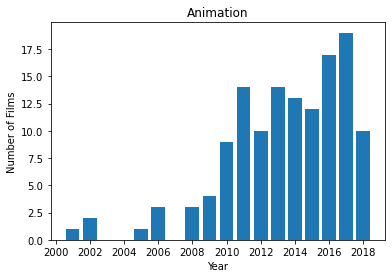

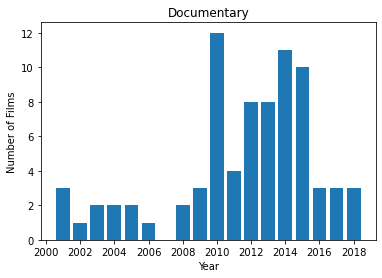

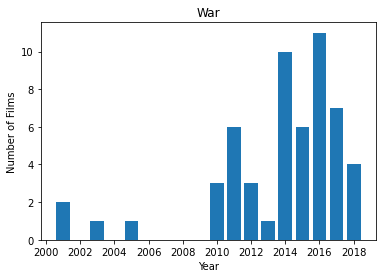

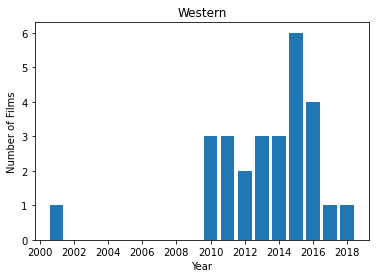

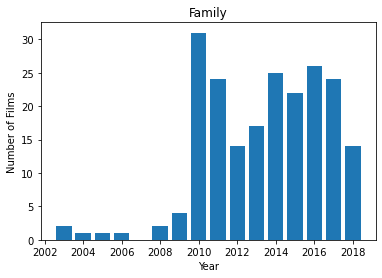

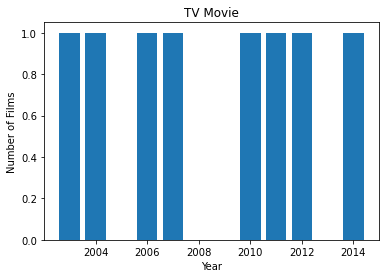

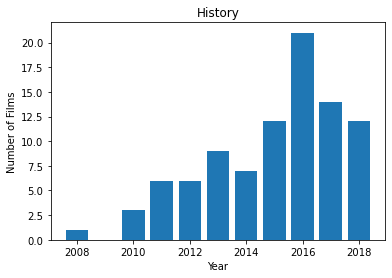

In [20]:
for genre in plt_dict:
    
    plt.figure()
    title = genre
    x_lab = 'Year'
    y_lab = 'Number of Films'
    list_obj = plt_dict[genre]
    x = [a[0] for a in list_obj]
    y = [b[1] for b in list_obj]
    xint = range(2000, 2019, 2)
    plt.xticks(xint)
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

### Percent Share of Market Total Films Produced Per Year By Genre

In [21]:
ww_films_per_year = df_grand.drop_duplicates().groupby('release_date')['worldwide_gross'].count()

In [22]:
years = ww_films_per_year.index
num_films = ww_films_per_year.values

ww_films_per_year_dict = {y:n for y,n in zip(years,num_films)}

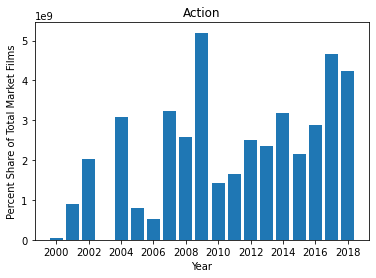

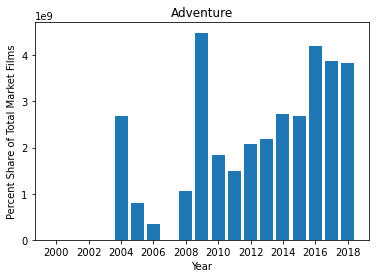

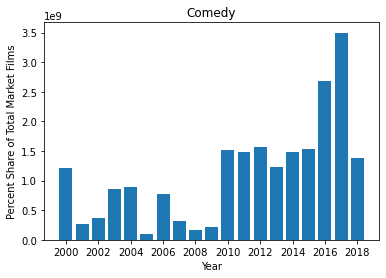

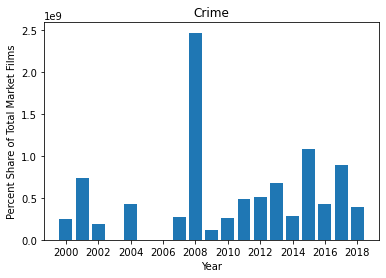

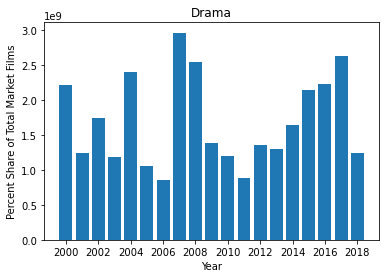

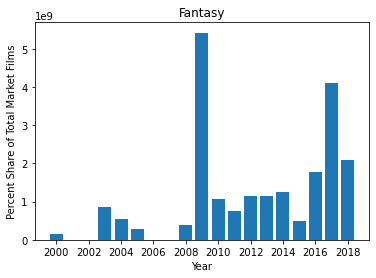

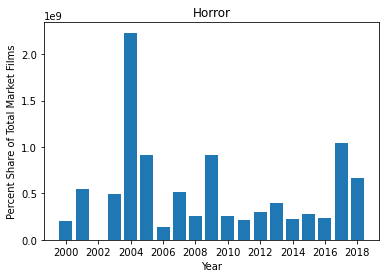

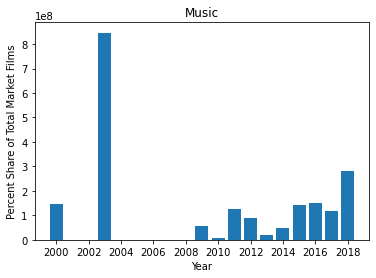

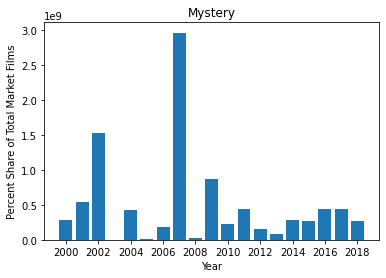

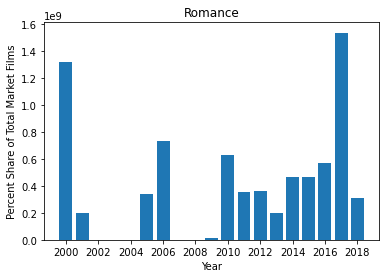

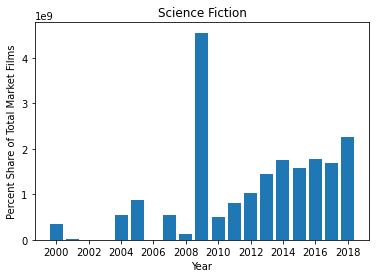

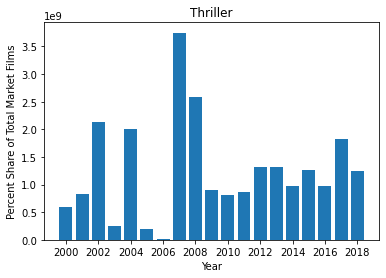

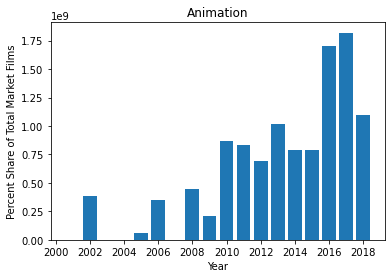

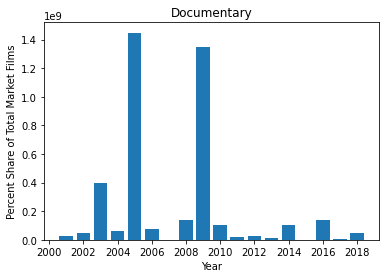

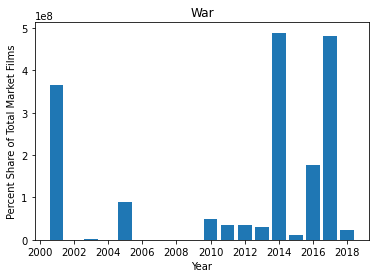

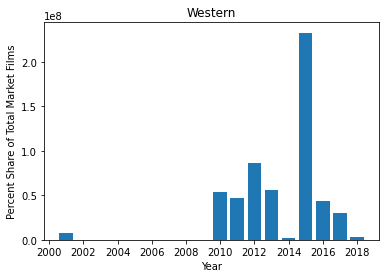

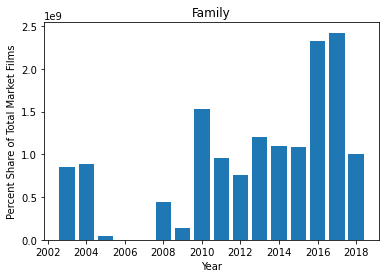

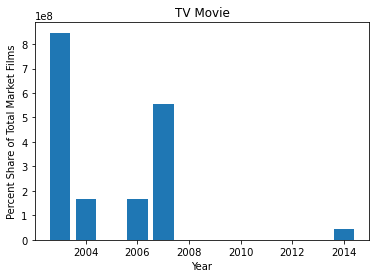

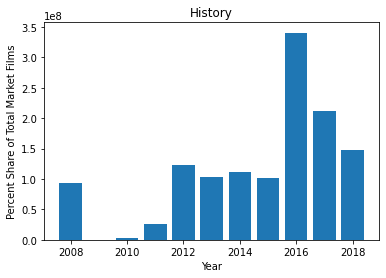

In [55]:
for genre in plt_dict:
    
    plt.figure()
    title = genre
    x_lab = 'Year'
    y_lab = 'Percent Share of Total Market Films'
    list_obj = plt_dict[genre]
    x = [a[0] for a in list_obj]
    y = [b[1]*100/ww_films_per_year_dict[b[0]] for b in list_obj]
    xint = range(2000, 2019, 2)
    plt.xticks(xint)
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

### Revenue Per Year by Genre

In [24]:
rev_per_year = df_grand.groupby(['release_date','genre_ids'])['worldwide_gross'].sum()

In [25]:
x = rev_per_year.index
y = rev_per_year.values

In [26]:
plt_dict = {k[1]:[] for k in x}

for k,v in zip(x,y):
    tup_obj = (k[0],v)
    
    plt_dict[k[1]].append(tup_obj)

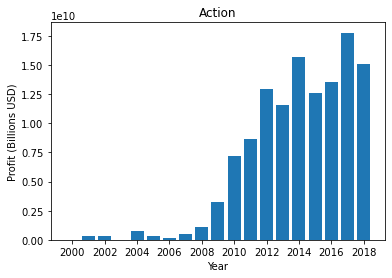

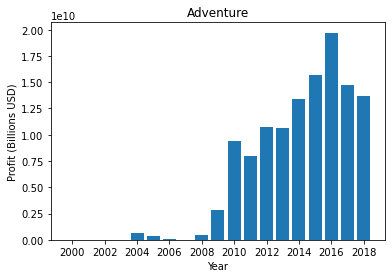

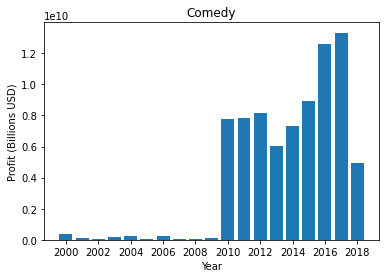

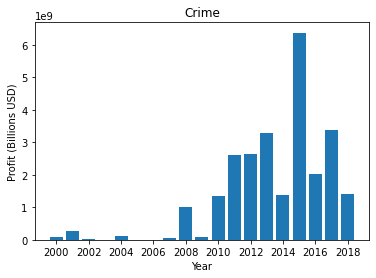

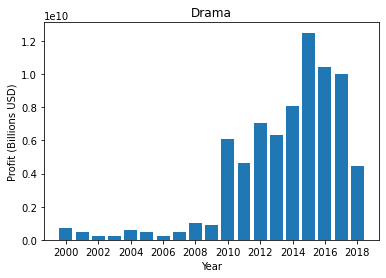

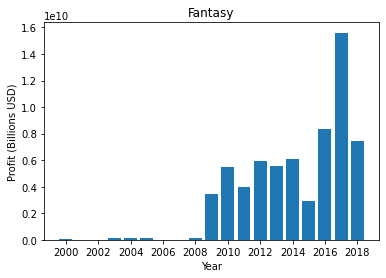

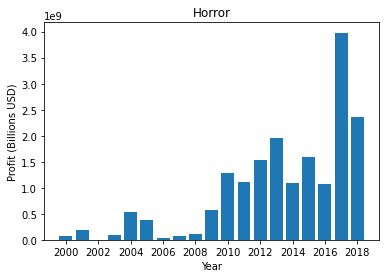

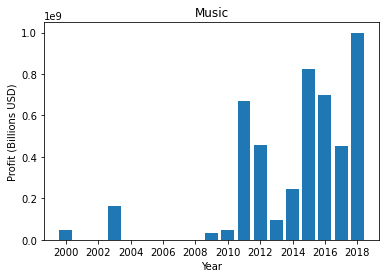

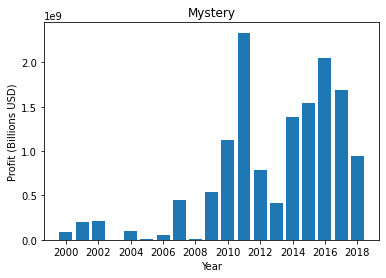

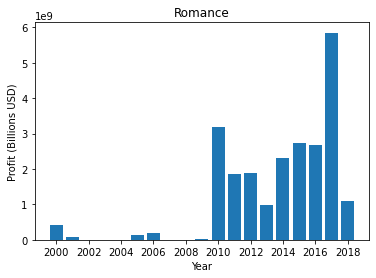

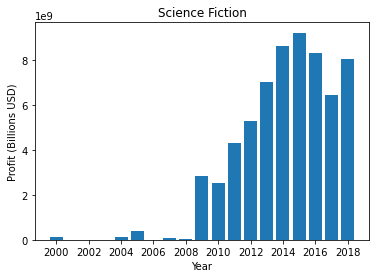

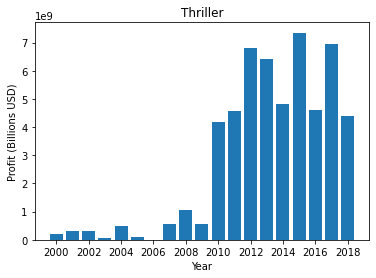

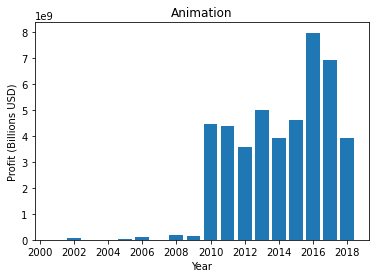

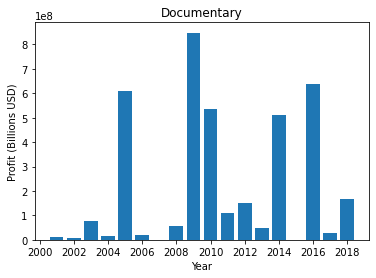

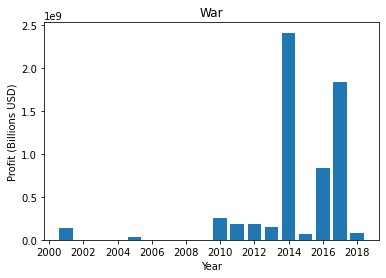

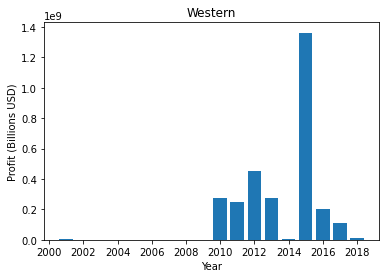

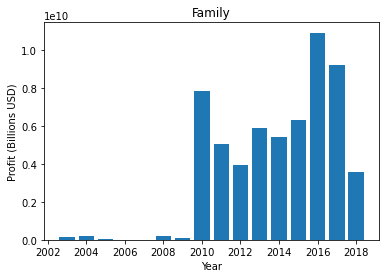

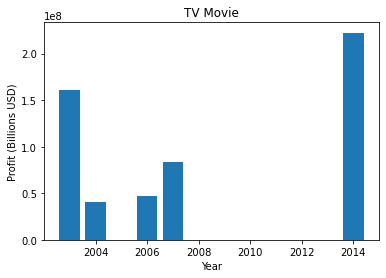

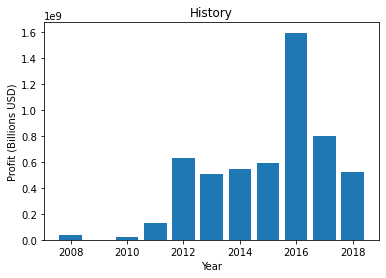

In [27]:
for genre in plt_dict:
    
    plt.figure()
    title = genre
    x_lab = 'Year'
    y_lab = 'Profit (Billions USD)'
    list_obj = plt_dict[genre]
    x = [a[0] for a in list_obj]
    y = [b[1] for b in list_obj]
    xint = range(2000, 2019, 2)
    plt.xticks(xint)
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

### Percent Share of Market Total Revenue Per Year By Genre

In [28]:
ww_rev_per_year = df_grand.drop_duplicates().groupby('release_date')['worldwide_gross'].sum()

In [29]:
f = list(ww_rev_per_year.index)
g = list(ww_rev_per_year.values)

w_dict = {year:rev for year,rev in zip(f,g)}

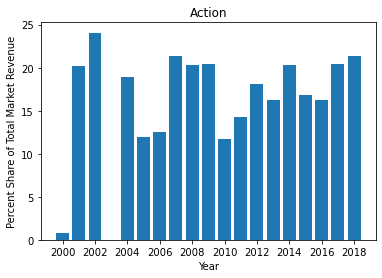

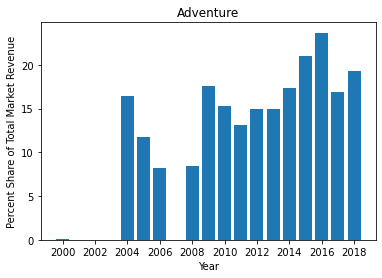

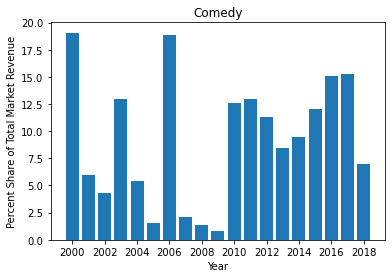

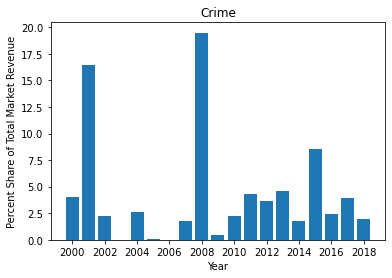

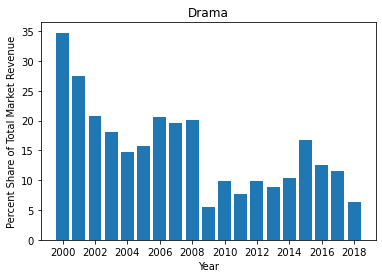

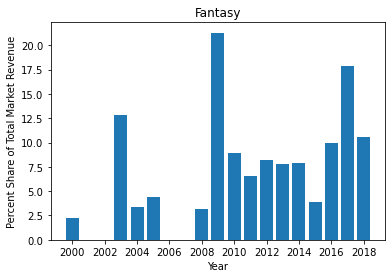

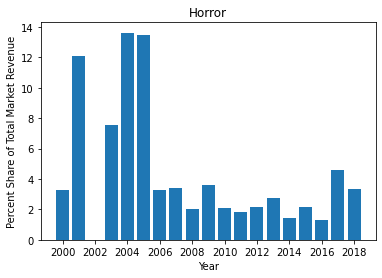

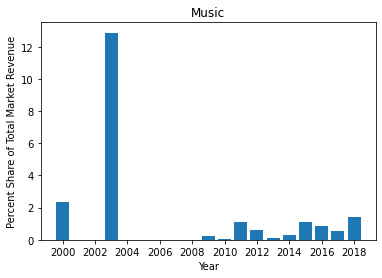

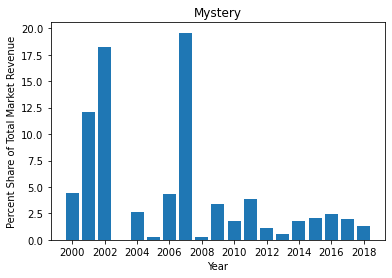

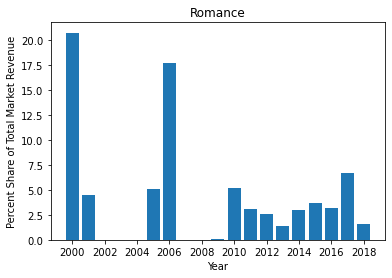

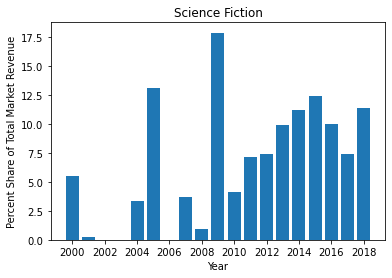

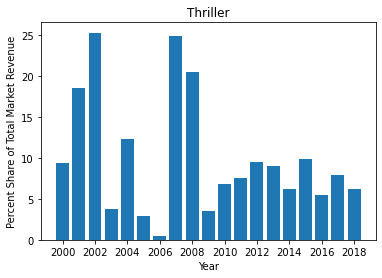

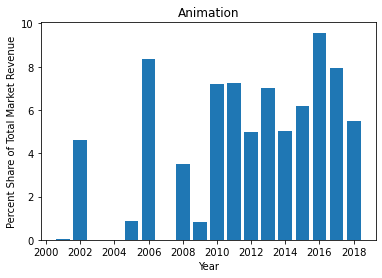

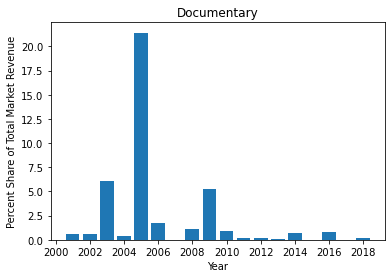

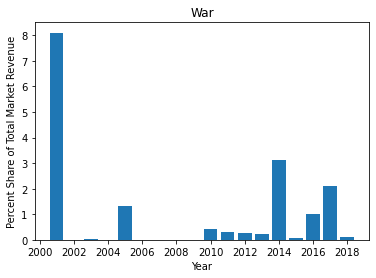

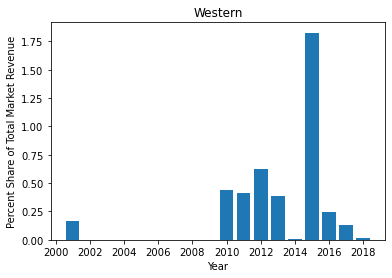

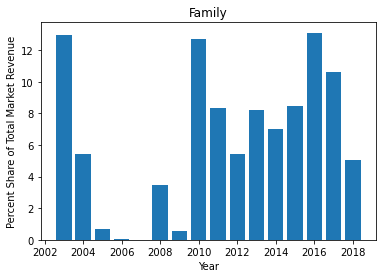

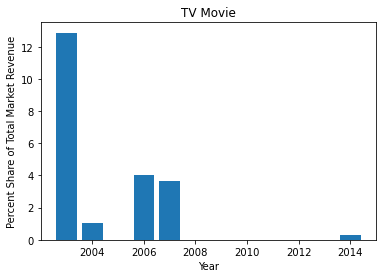

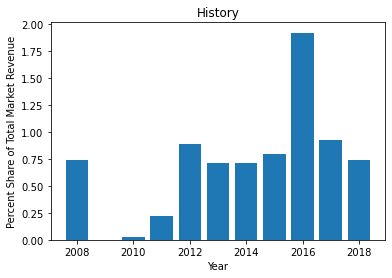

In [30]:
for genre in plt_dict:
    
    plt.figure()
    title = genre
    x_lab = 'Year'
    y_lab = 'Percent Share of Total Market Revenue'
    list_obj = plt_dict[genre]
    x = [a[0] for a in list_obj]
    y = [b[1]*100/w_dict[b[0]] for b in list_obj]
    xint = range(2000, 2019, 2)
    plt.xticks(xint)
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)

### Finding the Right Cast

In [31]:
# create df for casting
df1 = tmdb_df.set_index('title').join(tn_df.set_index('movie'))
df1.dropna(inplace=True)
action_movies = df1[df1['genre_ids'] == 'Action']
# clean
casting = imdb_df.set_index('primary_title').join(action_movies)
casting = casting.dropna().drop(['genres','start_year'], axis=1)
#preview
casting.head()

,primary_name,genre_ids,release_date,production_budget,worldwide_gross,profits,profitable
12 Strong,Jerry Bruckheimer,Action,2018,35000000.0,71118378.0,1118378.0,True
12 Strong,Peter Craig,Action,2018,35000000.0,71118378.0,1118378.0,True
12 Strong,Thad Luckinbill,Action,2018,35000000.0,71118378.0,1118378.0,True
12 Strong,Michael Peña,Action,2018,35000000.0,71118378.0,1118378.0,True
12 Strong,Michael Shannon,Action,2018,35000000.0,71118378.0,1118378.0,True
...,...,...,...,...,...,...,...
xXx: Return of Xander Cage,Donnie Yen,Action,2017,85000000.0,345033359.0,175033359.0,True
xXx: Return of Xander Cage,Deepika Padukone,Action,2017,85000000.0,345033359.0,175033359.0,True
xXx: Return of Xander Cage,Samantha Vincent,Action,2017,85000000.0,345033359.0,175033359.0,True
xXx: Return of Xander Cage,F. Scott Frazier,Action,2017,85000000.0,345033359.0,175033359.0,True


In [32]:
# actors with number of action films they've starred in
reliable_act_series = casting['primary_name'].value_counts()

In [33]:
# make dict for storage of data
cast_index = list(reliable_act_series.index)
cast_values = list(reliable_act_series.values)

cast_dict = {i:{'num_movies':v} for i,v in zip(cast_index, cast_values)}

In [34]:
# get average profit per movie for each actor, make dict
cast_avg_prof_index = list(casting.groupby('primary_name')['profits'].mean().index)
cast_avg_prof_values = list(casting.groupby('primary_name')['profits'].mean().values)

cast_avg_prof_dict = {k:v for k,v in zip(cast_avg_prof_index, cast_avg_prof_values)}

# add these values to cast_dict
for k in cast_dict:
    cast_dict[k]['avg_profit'] = cast_avg_prof_dict[k]

In [35]:
# get profitability likelihood for actors
prob_prof = (casting.groupby('primary_name')['profitable'].sum() / 
             casting.groupby('primary_name')['profitable'].count())

cast_prob_prof_index = list(prob_prof.index)
cast_prob_prof_values = list(prob_prof.values)

cast_prof_prof_dict = {k:v for k,v in zip(cast_prob_prof_index, cast_prob_prof_values)}

# add profitability likelihoods to  cast_dict
for k in cast_dict:
    cast_dict[k]['success_rate'] = cast_prof_prof_dict[k]

In [37]:
# make cast_stats df
df_index = cast_dict.keys()
df_values = [cast_dict[k] for k in cast_dict]

cast_stats_df = pd.DataFrame(data=df_values, index=df_index)

In [38]:
# explore stats
print(cast_stats_df.quantile(q=.6))
print()
print(cast_stats_df.quantile(q=.7))
print()
print(cast_stats_df.quantile(q=.8))
print()
print(cast_stats_df.quantile(q=.9))
print()
print(cast_stats_df.quantile(q=.95))

num_movies            1.0
avg_profit      6587268.0
success_rate          0.5
Name: 0.6, dtype: float64

num_movies      1.000000e+00
avg_profit      3.399705e+07
success_rate    1.000000e+00
Name: 0.7, dtype: float64

num_movies             2.0
avg_profit      88110562.5
success_rate           1.0
Name: 0.8, dtype: float64

num_movies              3.0
avg_profit      212157409.5
success_rate            1.0
Name: 0.9, dtype: float64

num_movies      4.000000e+00
avg_profit      3.693136e+08
success_rate    1.000000e+00
Name: 0.95, dtype: float64


In [39]:
# get cast that scores in selected percentile in in each category of measurement
power_staff = cast_stats_df[(cast_stats_df['num_movies'] > 6) &
                            (cast_stats_df['avg_profit'] > 25000000) &
                            (cast_stats_df['success_rate'] > .7)]

# drop directors from df
directors = ['Simon Kinberg','Beau Flynn',
             'Michael Bay','Christopher McQuarrie',
             'Kevin Feige','Richard Wenk',
             'Neal H. Moritz','Zack Snyder']

power_staff = power_staff.drop(directors)

In [40]:
# clean up for readability
power_staff['success_rate'] = round(power_staff['success_rate'] * 100, 1)
power_staff['avg_profit'] = round(power_staff['avg_profit']/1000000, 2)

power_staff.rename(columns={'num_movies':'Number of Movies',
                            'avg_profit':'Average Profit (Millions USD)',
                            'success_rate':'Box Office Success Rate'}, inplace=True)

In [41]:
# get all movies with a power_staff star
exp_df = casting[casting['primary_name'].isin(power_staff.index)]

In [42]:
# clean up for readability and interpretability
exp_df['production_budget'] = exp_df['production_budget'].map(lambda x: x/100000000)
exp_df['profits'] = exp_df['profits'].map(lambda x: x/100000000)

<ipython-input-42-70ca42ee55b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['production_budget'] = exp_df['production_budget'].map(lambda x: x/100000000)
<ipython-input-42-70ca42ee55b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['profits'] = exp_df['profits'].map(lambda x: x/100000000)


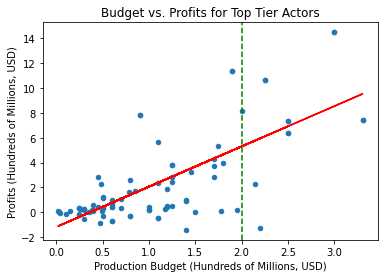

In [43]:
x=exp_df['production_budget']
y=exp_df['profits']

ax = exp_df.plot(x='production_budget', y='profits', kind='scatter', 
                 title='Budget vs. Profits for Top Tier Actors');

ax.set_xlabel('Production Budget (Hundreds of Millions, USD)');
ax.set_ylabel('Profits (Hundreds of Millions, USD)');

m, b = np.polyfit(x, y, 1);
plt.plot(x, m*x + b, color='red');
plt.axvline(x=2., color='green', linestyle='--');

In [44]:
exp_df.corr()

,production_budget,worldwide_gross,profits
production_budget,1.000000,0.862271,0.724862
worldwide_gross,0.862271,1.000000,0.973916
profits,0.724862,0.973916,1.000000


In [45]:
# find unprofitable film with production budget over $200M; it's Battleship
exp_df[exp_df['profits'] < 0]

,primary_name,genre_ids,release_date,production_budget,worldwide_gross,profits,profitable
Battleship,Liam Neeson,Action,2012,2.200,313477717.0,-1.265223,False
Faster,Dwayne Johnson,Action,2010,0.240,35792945.0,-0.122071,False
Free Fire,Sharlto Copley,Action,2017,0.100,3793739.0,-0.162063,False
Gods of Egypt,Gerard Butler,Action,2016,1.400,138836756.0,-1.411632,False
Jonah Hex,Josh Brolin,Action,2010,0.470,11022696.0,-0.829773,False
Machine Gun Preacher,Gerard Butler,Action,2011,0.300,3721988.0,-0.562780,False
Run All Night,Liam Neeson,Action,2015,0.500,66961644.0,-0.330384,False
The A-Team,Liam Neeson,Action,2010,1.100,177241171.0,-0.427588,False
The A-Team,Sharlto Copley,Action,2010,1.100,177241171.0,-0.427588,False
The Avengers,Robert Downey Jr.,Action,1998,0.600,48585416.0,-0.714146,False


In [46]:
# find out how profitability falls in gaussian
tn_df.quantile(.95)

production_budget    1.200000e+08
worldwide_gross      3.874767e+08
profits              2.362417e+08
profitable           1.000000e+00
Name: 0.95, dtype: float64

## Results
***

### Optimal Candidate Criteria 1: A Secure Genre

To ensure that the chance of profit in the event of a crapshoot is relatively likely, we measured genre profitability likelihood as the number of profitable films over the past 20 years divided by total films of that genre for the past 20 years.

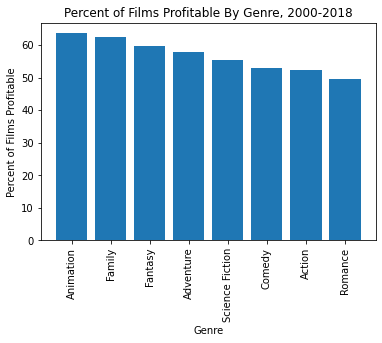

In [47]:
Image('images/prof_by_genre.png')

The above genres on the y-axis are relatively likely to be profitable, with roughly 53% of action films being profitable.

### Optimal Candidate Criteria 2: Large and Growing Market

From the several genres available, we have seelcted action because it is both large and growing market. Additionally, it accounts for a disproportionate percent revenue of total market compared to percent number of films of total market, which further bolsters the argument for a foray into the action genre.

<b>Large:</b> important because it indicates the audience size which directly correlates with profitability; also because it shows that the market will be easier to infiltrate.

<b>Growing:</b> important because it indicates that there is free value to capture.

##### Number of Action Movies Per Year

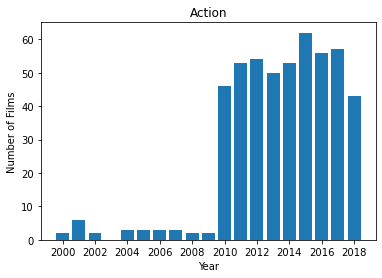

In [48]:
Image('images/action_num_films.png')

As we can see, there is a general positive trend, which indicates that the action genre is becoming more popular.

##### Number of Action Films Per Year By Percent Share of Total Films

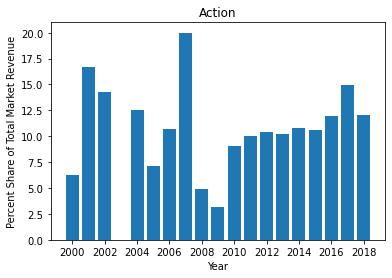

In [49]:
Image('images/action_percent_films.png')

We can see that the action genre consistently accounts for roughly 12% of the total market in terms of number of films. This indicates that the action genre is comparatively large, thus easier to infiltrate. The action genre is also growing relative to total market, as we can see from the trend.

##### Action Revenue Per Year

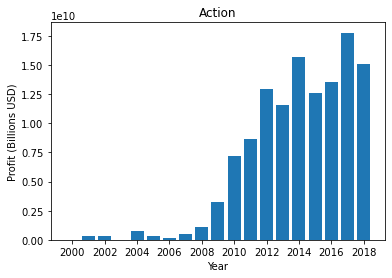

In [50]:
Image('images/action_revenue.png')

As one might expect, the total revenue is both large and growing for the action genre, which is an even stronger argument for the its popularity and infiltratability. 

##### Action Revenue Per Year by Percent Share of Total Market 

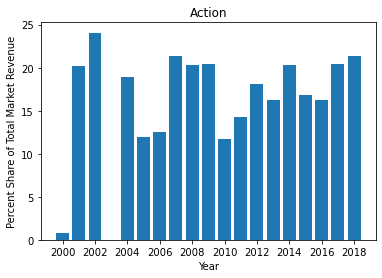

In [51]:
Image('images/action_percent_revenue.png')

Finally, we can see that action genre is growing in its percent of the total market revenue. NOTE: While only accounting for roughly 12% of total movies produced, action boasts a consistent 15-20% share of total market revenue - and growing.

Based on the above information, we have determined that the action genre is the best genre for Microsoft as it is both sufficiently large and reliably growing, both to a higher degree than any other genre. Reference the analysis for further reasoning.

### Optimal Candidate 3: Ensuring Profitability

Finally, we found that within the action genre, the cast has a large deal to do with the risk as well as the overall profitability of the film. One might expect that hiring an A-list cast would make for better box office numbers, and our analysis confirms this. 

##### Powerful Potential Cast Members

In [52]:
power_staff

,Number of Movies,Average Profit (Millions USD),Box Office Success Rate
Dwayne Johnson,16,306.33,93.8
Liam Neeson,14,59.93,71.4
Tom Cruise,10,61.20,100.0
Chris Evans,9,475.49,77.8
Gerard Butler,9,38.08,77.8
Robert Downey Jr.,9,637.66,88.9
Vin Diesel,8,352.50,75.0
Sharlto Copley,7,58.03,71.4
Josh Brolin,7,108.98,85.7


From the above table, we can see that some actors within the action genre are highly associated with box office success in terms of likelihood and magnitude of outcome. With this insight, we recommend choosing a name from the above list to star in your debut film. 

### Optimization of All Previous Parameters for Profit Maximization

Finally, we tracked the relationship between production budget and average profit, given an action film starring an A-list actor. We found that a higher budget almost always leads to a higher profit.

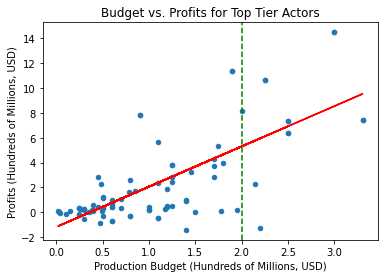

In [53]:
Image('images/budg_prof.png')

The red line indicates the line of best fit, which has a slope of about 3/4. This means that every 4 dollars of budget translates to 3 dollars of profit, roughly speaking. Further, we noticed that 200M USD (green line) was something of a magic number in terms of shielding against the possibility of loss as well as maximizing profits. Our final recommendation is to invest at least 200M USD for production budget, as this will likely put you in the 96th percentile of all films across all genres in terms of profitability. 

## Conclusions

We yield three recommendations to Microsoft Studios for maximizing profit and minimizing risk in its foray into the film industry:
- Enter the industry with an action film because (1) it is a secure genre in terms of likelihood of film box office success; (2) it is a large/popular genre, indicating greater ease of infiltration and guaranteed market; (3) it is a growing market with disproportionately more revenue than films per year as compared to other genres.
- Hire an A-list main character. As long as you hire from the list we've supplied, you can be all but certain that your film with be a box office success.
- Choose a budget exceeding 200M USD. Over 50% of action movies with an A-list cast member equipped with this budget gross over 1B USD in revenue. This will not only guarantee the box office success of the film, but will also establish Microsoft as a big player in the film world. 

## Future Research

A last idea to mention, many of the most profitable films of all time are based on popular fiction literature. Think of Lord of the Rings, The Avengers, and Harry Potter. We recommend that Microsoft research into pop culture to find a similar candidate. This will provide the rock upon which Microsoft can build its castle. 